In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL de la page des avis
base_url = "https://www.airlinequality.com/airline-reviews/british-airways/page/{}/?sortby=post_date%3ADesc"

# Fonction pour récupérer les avis d'une page donnée
def scrape_reviews(page_url):
    response = requests.get(page_url)
    soup = BeautifulSoup(response.content, "html.parser")
    
    reviews = []
    # Sélectionner les sections contenant les avis
    review_blocks = soup.find_all("article", itemprop="review")
    
    for review in review_blocks:
        # Récupérer les informations
        title = review.find("h2", class_="text_header").get_text(strip=True) if review.find("h2", class_="text_header") else None
        rating_tag = review.find("span", itemprop="ratingValue")
        rating = int(rating_tag.get_text(strip=True)) if rating_tag else None
        date = review.find("meta", itemprop="datePublished")["content"] if review.find("meta", itemprop="datePublished") else None
        content = review.find("div", class_="text_content").get_text(strip=True) if review.find("div", class_="text_content") else None
        
        # Ajouter les données dans une liste
        reviews.append({
            "Title": title,
            "Rating": rating,
            "Date": date,
            "Content": content
        })
    
    return reviews



In [4]:
# # Pagination : scraper plusieurs pages
# all_reviews = []

# # Scraper les premières pages (ajustez la plage selon vos besoins)
# for page in range(1, 391): 
#     print(f"Scraping page {page}...")
#     page_url = base_url.format(page)
#     all_reviews.extend(scrape_reviews(page_url))

# # Convertir en DataFrame et sauvegarder les données
# df = pd.DataFrame(all_reviews)
# df.to_csv("british_airways_reviews.csv", index=False)
# print("Les avis ont été sauvegardés dans 'british_airways_reviews.csv'.")

In [5]:
import pandas as pd

# Load the scraped data
df = pd.read_csv("british_airways_reviews.csv")

# Remove the "Trip Verified" prefix from the Content column
df['Content'] = df['Content'].str.replace(r'✅Trip Verified\|', '', regex=True)

# Remove extra quotes from the Title column
df['Title'] = df['Title'].str.replace(r'^"|"$', '', regex=True)

# Convert the Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Check for missing values
print(df.isnull().sum(),"\n")

# Drop rows with missing values in the Rating column
df.dropna(subset=['Rating'], inplace=True)

# Save the cleaned data
df.to_csv("cleaned_british_airways_reviews.csv", index=False)

print("Après nettoyage\n")
print(df.isnull().sum())


Title      0
Rating     6
Date       0
Content    0
dtype: int64 

Après nettoyage

Title      0
Rating     0
Date       0
Content    0
dtype: int64


In [6]:
from textblob import TextBlob

# Function to calculate sentiment polarity
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply sentiment analysis to the Content column
df['Sentiment'] = df['Content'].apply(get_sentiment)

# Classify sentiment based on polarity
df['Sentiment_Label'] = df['Sentiment'].apply(
    lambda x: 'Positive' if x > 0 else ('Neutral' if x == 0 else 'Negative')
)

# Save the data with sentiment analysis
df.to_csv("british_airways_reviews_with_sentiment.csv", index=False)

# Print sentiment distribution
print(df['Sentiment_Label'].value_counts())

Sentiment_Label
Positive    2701
Negative    1172
Neutral       21
Name: count, dtype: int64


In [7]:
# Calculate the count of each rating
rating_counts = df['Rating'].value_counts().sort_index()

# Print the counts
print("Nombre total de chaque note :")
for rating, count in rating_counts.items():
    print(f"Note {rating} : {count} avis")


Nombre total de chaque note :
Note 1.0 : 948 avis
Note 2.0 : 442 avis
Note 3.0 : 436 avis
Note 4.0 : 262 avis
Note 5.0 : 240 avis
Note 6.0 : 204 avis
Note 7.0 : 313 avis
Note 8.0 : 386 avis
Note 9.0 : 322 avis
Note 10.0 : 341 avis


/tmp/ipykernel_41547/3351912248.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




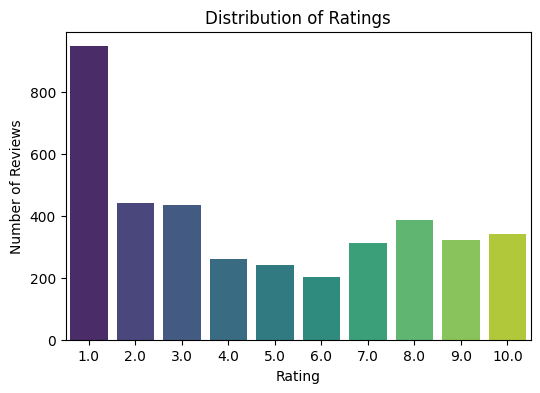

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of ratings
plt.figure(figsize=(6, 4))
sns.countplot(x='Rating', data=df, palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.show()

/tmp/ipykernel_41547/529631622.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




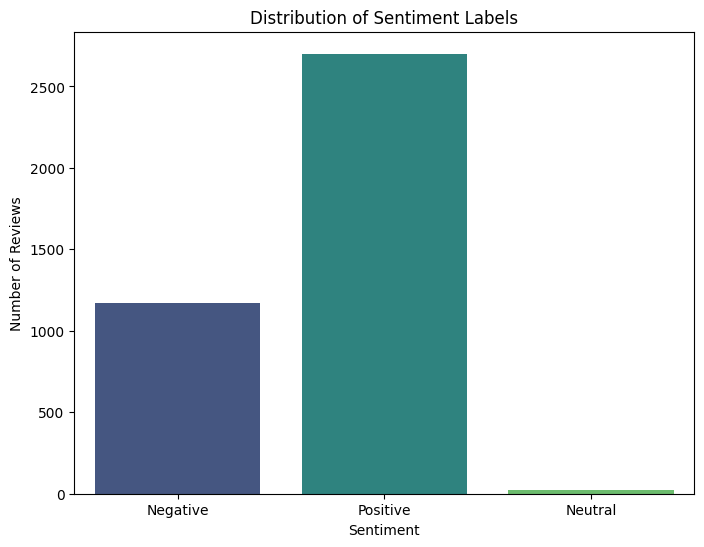

In [9]:
# Plot the distribution of sentiment labels
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment_Label', data=df, palette='viridis')
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

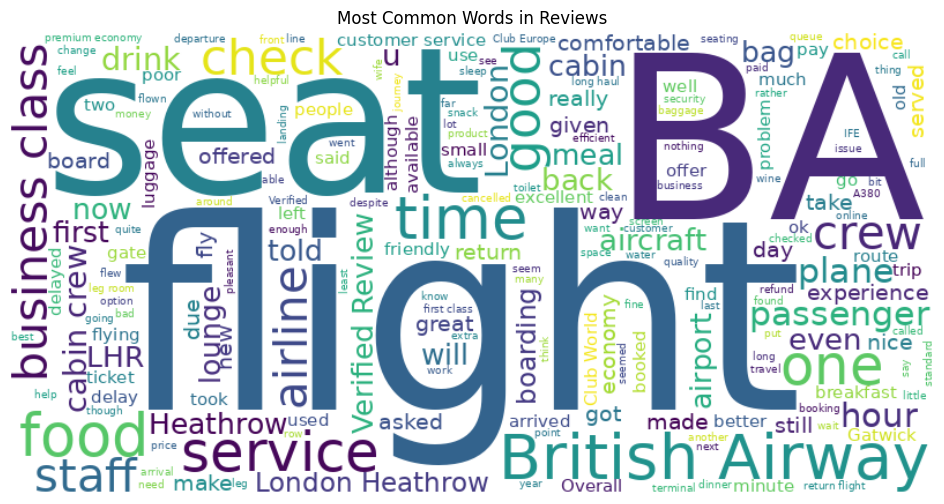

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Chemin vers une police système par défaut
font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"  # Exemple pour Linux
all_text = " ".join(df['Content'])


# Générer le nuage de mots avec la police spécifiée
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    font_path=font_path  # Utiliser la police spécifiée
).generate(all_text)

# Afficher le nuage de mots
plt.figure(figsize=(16, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Reviews')
plt.show()

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Vectorize the text data
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
text_matrix = vectorizer.fit_transform(df['Content'])

# Apply LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(text_matrix)

# Display the top words for each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Get the feature names
feature_names = vectorizer.get_feature_names_out()

# Display the top 10 words for each topic
display_topics(lda, feature_names, no_top_words=5)

Topic 1:
flight meal food chicken british
Topic 2:
flight crew good ba time
Topic 3:
seat seats economy flight food
Topic 4:
flight ba british airways london
Topic 5:
ba flight service class british


In [12]:
import plotly.express as px
import pandas as pd

# Données de répartition des sentiments
data = {
    "Sentiment": ["Positive", "Negative", "Neutral"],
    "Count": [2701, 1172, 21],
}
df_sentiment = pd.DataFrame(data)

# Créer un graphique en barres interactif
fig = px.bar(df_sentiment, x="Sentiment", y="Count", color="Sentiment",
             title="Distribution of Sentiments in Customer Reviews",
             text="Count")
fig.update_traces(textposition="outside")

# Sauvegarder le graphique en HTML
fig.write_html("sentiment_distribution.html")
print("Graphique interactif créé : 'sentiment_distribution.html'")


Graphique interactif créé : 'sentiment_distribution.html'
